In [1]:
%pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import tensorflow

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#!!!!! taken from train dataset
percentageOfTestDataset = 0.4

Num GPUs Available:  0


In [3]:
import csv
import random

PositiveImagePaths = []
NegativeImagePaths = []


with open("MURA-v1.1/valid_image_paths.csv", "r") as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        if "positive" in row[0].split("/")[4]:
          PositiveImagePaths.append(row[0])
        else : NegativeImagePaths.append(row[0])
        
random.shuffle(PositiveImagePaths)
random.shuffle(NegativeImagePaths)
            
print(len(PositiveImagePaths))
print(len(NegativeImagePaths))


import shutil
count = 0

for x in PositiveImagePaths:
    count = count + 1
    with open(x, 'rb') as fin:
        with open("MURA-2folder/valid/positive/"+str(count)+".png", 'wb') as fout:
            shutil.copyfileobj(fin, fout, 2048*1024)

print(count)
count = 0

for x in NegativeImagePaths:
    count = count + 1
    with open(x, 'rb') as fin:
        with open("MURA-2folder/valid/negative/"+str(count)+".png", 'wb') as fout:
            shutil.copyfileobj(fin, fout, 2048*1024)
            
print(count)

1530
1667
1530
1667


In [4]:
PositiveImagePaths = []
NegativeImagePaths = []


with open("MURA-v1.1/train_image_paths.csv", "r") as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        if "positive" in row[0].split("/")[4]:
          PositiveImagePaths.append(row[0])
        else : NegativeImagePaths.append(row[0])
        
random.shuffle(PositiveImagePaths)
random.shuffle(NegativeImagePaths)
            
print(len(PositiveImagePaths))
print(len(NegativeImagePaths))


import shutil
count = 0

for x in PositiveImagePaths:
    count = count + 1
    with open(x, 'rb') as fin:
        if count > len(PositiveImagePaths)*0.4 :
            with open("MURA-2folder/train/positive/"+str(count)+".png", 'wb') as fout:
                shutil.copyfileobj(fin, fout, 2048*1024)
        else : 
            with open("MURA-2folder/test/positive/"+str(count)+".png", 'wb') as fout:
                shutil.copyfileobj(fin, fout, 2048*1024)

print(count)
count = 0

for x in NegativeImagePaths:
    count = count + 1
    with open(x, 'rb') as fin:
        if count > len(NegativeImagePaths)*0.4 :
            with open("MURA-2folder/train/negative/"+str(count)+".png", 'wb') as fout:
                shutil.copyfileobj(fin, fout, 2048*1024)
        else : 
            with open("MURA-2folder/test/negative/"+str(count)+".png", 'wb') as fout:
                shutil.copyfileobj(fin, fout, 2048*1024)
            
print(count)

14873
21935
14873
21935


In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

trainDs = image_dataset_from_directory("MURA-2folder/train",
                            labels='inferred',
                            label_mode='binary',
                            color_mode='grayscale',
                            shuffle=False,
                            batch_size=1,
                            image_size=(224, 224)
                            )

#testDs used as TEST dataset
testDs = image_dataset_from_directory("MURA-2folder/test",
                            labels='inferred',
                            label_mode='binary',
                            color_mode='grayscale',
                            shuffle=False,
                            batch_size=1,
                            image_size=(224, 224)
                            )

validDs = image_dataset_from_directory("MURA-2folder/valid",
                            labels='inferred',
                            label_mode='binary',
                            color_mode='grayscale',
                            shuffle=False,
                            batch_size=1,
                            image_size=(224, 224)
                            )


print(trainDs)
print(trainDs.class_names)

Found 22085 files belonging to 2 classes.
Found 14723 files belonging to 2 classes.
Found 3197 files belonging to 2 classes.
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
['negative', 'positive']


In [6]:
count1 = 0
count2 = 0

for i,label in trainDs :
    if label == 0:
        count1 = count1 + 1
    else :
        count2 = count2 + 1
print(count1)
print(count2)

count1 = 0
count2 = 0

for i,label in validDs :
    if label == 0:
        count1 = count1 + 1
    else : count2 = count2 + 1
print(count1)
print(count2)

count1 = 0
count2 = 0

for i,label in testDs :
    if label == 0:
        count1 = count1 + 1
    else : count2 = count2 + 1
print(count1)
print(count2)

13161
8924
1667
1530
8774
5949


In [38]:
for i,label in trainDs.take(10) :
    print(label)

tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


In [52]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras import Model

#alpha: If alpha < 1.0, proportionally decreases the number of filters in each layer.
#classifier_activation: Set classifier_activation=None to return the logits of the "top" layer.
MobileNetV2 = MobileNetV2(input_shape=(224,224,3), alpha=1, weights='imagenet', classifier_activation=None)
print("Num of layers in MobileNetV2: ",len(MobileNetV2.layers))

#We chose last 5 layers of MobileNetV2 trainable
for layer in MobileNetV2.layers[:-5] :
    layer.trainable = False


#Added below layers cause our images are greyscale (224,224,1)
input_tensor = Input(shape=(224,224,1) )
img_conc = Concatenate()([input_tensor, input_tensor, input_tensor])       # x has a dimension of (IMG_SIZE,IMG_SIZE,3)

preprocessed_tensor = tensorflow.keras.applications.mobilenet.preprocess_input(img_conc)
out = MobileNetV2(preprocessed_tensor) 

base_model = Model(inputs=input_tensor,outputs=out)

print(base_model.summary())


Num of layers in MobileNetV2:  156
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 224, 224, 3)  0           ['input_6[0][0]',                
                                                                  'input_6[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 tf.math.truediv_2 (TFOpLambda)  (None, 224, 224, 3)  0  

In [53]:
MobileNetV2.layers[-5:]

In [41]:
%pip install keras-tuner

We used 1000 train and 100 valid images in order for keras tuner to run in a good amount of time to find best hyperparameters.
We did it cause we cant use a GPU in order to make the calculations faster. Same reason why we didn't use ImageDataGenerator().

In [55]:
import keras_tuner as kt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import BinaryCrossentropy 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import numpy as np


def model_builder(hp):
  model = Sequential()

  model.add(base_model)
  # Αdd a hidden MLP layer
  for i in range(hp.Int('mlp_hidden_layers', 0, 1)):
    hp_dropout = hp.Choice('dropout_rate1_' + str(i), values=[0.3, 0.4, 0.5])
    model.add(Dropout(hp_dropout))
    hp_dense = hp.Choice('DENSE_units_' + str(i), values=[512, 256, 128])
    model.add(Dense(hp_dense, activation='relu' ))

  # Αdd the output MLP layer
  hp_dropout = hp.Choice('dropout_rate2', values=[0.3, 0.4, 0.5])
  model.add(Dropout(hp_dropout))
  model.add(Dense(1, activation='sigmoid'))

  hp_learning_rate = hp.Choice('learning_rate', values=[2e-3, 1e-3, 9e-4])

  model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss=BinaryCrossentropy(),
                metrics=['accuracy', 'cosine_proximity'])

  return model

tuner = kt.BayesianOptimization(model_builder,
                    objective='val_accuracy',
                    max_trials=4,
                    overwrite=True,
                    )

tuner.search_space_summary()

stop_early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=1, #just 1 for tuner -- for speed
                                              min_delta=0.001,
                                              mode='auto')

#--------------------------------------------------------
#!!!!!!!!!!!!!!
#We use .shuffle()  to include both classes to data cause they are in order negative positive at dataset variables
#!!!!!!!!!!!!!!
#At next cell where we have last model we dont have to use it, but we could for randomness
#--------------------------------------------------------

tuner.search(trainDs.shuffle(len(trainDs)).take(1000), 
             batch_size=32,
             epochs=5, 
             callbacks=[stop_early],
             validation_data=validDs.shuffle(len(validDs)).take(100)
             )

best_model = tuner.get_best_models()[0]

best_hyperparameters = tuner.get_best_hyperparameters()[0]
print(best_hyperparameters.values)

Search space summary
Default search space size: 3
mlp_hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 1, 'step': 1, 'sampling': None}
dropout_rate2 (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.4, 0.5], 'ordered': True}
learning_rate (Choice)
{'default': 0.002, 'conditions': [], 'values': [0.002, 0.001, 0.0009], 'ordered': True}

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0                 |?                 |mlp_hidden_layers
0.3               |?                 |dropout_rate2
0.0009            |?                 |learning_rate

Epoch 1/5
125/500 [======>.......................] - ETA: 1:54 - loss: 3.1317 - accuracy: 0.5120 - cosine_proximity: 0.3833

KeyboardInterrupt: 

Below we redefine our model with the best hyperparameters we found with keras tuner.
And run it with our train and valid datasets. Utilizing early stopping for 12 epochs. 

In [47]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import BinaryCrossentropy 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import numpy as np

# {'mlp_hidden_layers': 1, 'dropout_rate1_0': 0.5, 'DENSE_units_0': 512, 'dropout_rate2': 0.5,
#  'learning_rate': 0.0009, ######'dropout_rate1_1': 0.3, 'DENSE_units_1': 256}

model = Sequential()

model.add(base_model)

# Αdd MLP layers
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu' ))

# Αdd the output MLP layer
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0009),
            loss=BinaryCrossentropy(),
            metrics=['accuracy', 'cosine_proximity'])

print(model.summary())

checkpoint = ModelCheckpoint(
    'checkpoints/weights',
    monitor='val_accuracy', 
    mode='auto', 
    verbose=2,
    save_best_only=True,
    save_weights_only=True
    )

early_stopping = EarlyStopping(
   monitor='val_accuracy',
   min_delta=0.0001,
   patience=3,
   verbose=2,
   mode='auto',
   )

history = model.fit(
    trainDs,
    validation_data=validDs, 
    batch_size=32,
    epochs=12,
    shuffle=True,
    callbacks=[checkpoint, early_stopping]
    )

model.save('model')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 1000)              3538984   
                                                                 
 dropout_2 (Dropout)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               512512    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 4,052,009
Trainable params: 2,206,185
Non-trainable params: 1,845,824
_________________________________________________________________
None
Epoch 1/12


KeyboardInterrupt: 

In [16]:
#model.save_weights('modelh5/weights.h5')

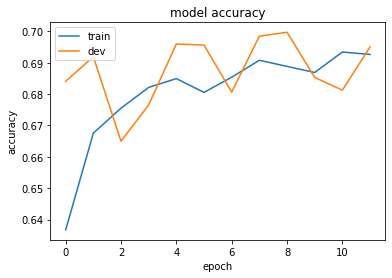

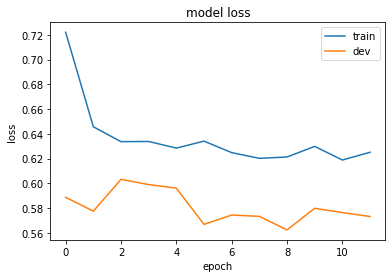

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

def loss_curve(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'dev'], loc='upper left')
  plt.show()
  
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'dev'], loc='upper right')
  plt.show()


loss_curve(history)

In [20]:
evaluateScores = model.evaluate(trainDs)
print('Train Scores:', evaluateScores)
print('Train loss:', evaluateScores[0])
print('Train accuracy:', evaluateScores[1])

evaluateScores = model.evaluate(validDs)
print('Valid Scores:', evaluateScores)
print('Valid loss:', evaluateScores[0])
print('Valid accuracy:', evaluateScores[1])

evaluateScores = model.evaluate(testDs)
print('Test Scores:', evaluateScores)
print('Test loss:', evaluateScores[0])
print('Test accuracy:', evaluateScores[1])

22085/22085 [==============================] - 813s 37ms/step - loss: 0.5397 - accuracy: 0.7395 - cosine_proximity: 0.4101
Train Scores: [0.5397195219993591, 0.7394611835479736, 0.4100973606109619]
Train loss: 0.5397195219993591
Train accuracy: 0.7394611835479736
3197/3197 [==============================] - 116s 36ms/step - loss: 0.5732 - accuracy: 0.6950 - cosine_proximity: 0.4786
Valid Scores: [0.5731682777404785, 0.6950265765190125, 0.47857365012168884]
Valid loss: 0.5731682777404785
Valid accuracy: 0.6950265765190125
14723/14723 [==============================] - 548s 37ms/step - loss: 0.5669 - accuracy: 0.7299 - cosine_proximity: 0.3950
Test Scores: [0.5669307112693787, 0.7299463152885437, 0.39502817392349243]
Test loss: 0.5669307112693787
Test accuracy: 0.7299463152885437


In [18]:
# #scores
# from sklearn.metrics import f1_score,precision_score,recall_score,precision_recall_curve,auc,average_precision_score
# from sklearn.metrics import accuracy_score
# import pandas as pd
# import numpy as np

# #All needed scores to be calaculated for each estimator later
# def scores(y, predictions, probs, soft_pred=None) :
#   score = precision_score(y, predictions,pos_label=0)
#   print("Negative class precision: {:.2f}%".format(score*100))
#   score = precision_score(y, predictions,pos_label=1)
#   print("Positive class precision: {:.2f}%".format(score*100))
#   score = recall_score(y, predictions,pos_label=0)
#   print("Negative class recall: {:.2f}%".format(score*100))
#   score = recall_score(y, predictions,pos_label=1)
#   print("Positive class recall: {:.2f}%".format(score*100))
#   score = f1_score(y,predictions,pos_label=0)
#   print("Negative class f1-score: {:.2f}%".format(score*100))
#   score = f1_score(y,predictions,pos_label=1)
#   print("Positive class f1-score: {:.2f}%".format(score*100))

#   print("--- MACRO-AVERAGED RESULTS ---\n")
#   #MACRO
#   score = precision_score(y, predictions, average='macro')
#   print("macro-precision: {:.2f}%".format(score*100))
#   score = recall_score(y, predictions, average='macro')
#   print("macro-recall: {:.2f}%".format(score*100))
#   score = f1_score(y,predictions, average='macro')
#   print("macro-f1-score: {:.2f}%".format(score*100))
  
  
# def predict_results(dataSetToTest) :
#     #PREDICTIONS
#     probs = model.predict(dataSetToTest)
    
#     #print(probs)
    
#     preds_01 = []
#     for p in probs:
#         if p > 0.5:
#             preds_01.append(1)
#         else : preds_01.append(0)
        
#     #print(preds_01)

#     #REAL Y
#     real_y = []
#     for bX, by in dataSetToTest: 
#         real_y.append(int(by))

#     #print(real_y)

#     scores(real_y,preds_01,probs)

In [ ]:
# #TRAIN
# print('\nTraining results:\n')
# predict_results(trainDs)

# #VALID / DEVELOPMENT
# print('\nDevelopment results:\n')
# predict_results(validDs)

# #TEST
# print('\nTest results:\n')
# predict_results(testDs)